# show saliency maps

In [1]:
from func.loadimg import get_example_pic_and_preprocess, generate_example_list, get_file_path
from func.utils import get_pretrained_model, preprocess_image, convert_to_grayscale, format_np_output, save_image, save_gradient_images, get_positive_negative
from func.saliency_maps import GuidedBackprop, VanillaBackprop, SmoothGrad, GradCAM, GuidedGradCAM, IntegratedGradients, GradientxInput, DeepLIFT

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sample_data_filepath = os.path.abspath(os.path.join(get_file_path(), ".."))+"/data"

### some funcitons for illustration

In [2]:
# a unified way to conduct saliency map methods
def conduct_saliency_map_method(METHOD, processed_img_tensor, target_class_index, pretrained_model, which_layer_to_hook=0):
    saliency_map_method = METHOD(pretrained_model, which_layer_to_hook)
    saliency_map, feature_map = saliency_map_method.generate_explanation(processed_img_tensor, target_class_index)
    return saliency_map, feature_map, saliency_map_method

# used to show saliency maps
def process_results_for_one_method(saliency_map, feature_map):
    
    grayscale_saliency_map = convert_to_grayscale(saliency_map)[0]
    grayscale_feature_map = convert_to_grayscale(feature_map)[0]
    
    pos_saliency_map, neg_saliency_map = get_positive_negative(saliency_map)
    blank = np.zeros(pos_saliency_map.shape)
    pos_neg_saliency_map = np.concatenate((pos_saliency_map,blank,neg_saliency_map),axis=0)
    pos_neg_saliency_map = pos_neg_saliency_map.transpose(1,2,0)
    
    return grayscale_saliency_map, grayscale_feature_map, pos_neg_saliency_map

def show_results_for_one_method(original_image, saliency_map, feature_map, which_layer_to_hook, color_map = "gray"):
    
    grayscale_saliency_map, grayscale_feature_map, pos_neg_saliency_map = process_results_for_one_method(saliency_map, feature_map)
    
    plt.figure(figsize = (15,20))
    
    if which_layer_to_hook == 0:
        ax1 = plt.subplot(1,3,1)
        ax1.set_title("input image")
        ax1.imshow(original_image)
        
        ax2 = plt.subplot(1,3,2)
        ax2.set_title("grayscale saliency map")
        ax2.imshow(grayscale_saliency_map, cmap=plt.get_cmap(color_map))
        
        ax3 = plt.subplot(1,3,3)
        ax3.set_title("saliency map (pos: red, neg: blue)")
        ax3.imshow(pos_neg_saliency_map)
        
        plt.show()
    else:
        ax1 = plt.subplot(1,4,1)
        ax1.set_title("input image")
        ax1.imshow(original_image)
        
        ax2 = plt.subplot(1,4,2)
        ax2.set_title("grayscale saliency map")
        ax2.imshow(grayscale_saliency_map, cmap=plt.get_cmap(color_map))
        
        ax3 = plt.subplot(1,4,3)
        ax3.set_title("saliency map (pos: red, neg: blue)")
        ax3.imshow(pos_neg_saliency_map)
        
        ax4 = plt.subplot(1,4,4)
        ax4.set_title("grayscale feature map")
        ax4.imshow(grayscale_feature_map, cmap=plt.get_cmap(color_map))
        
        plt.show()

In [3]:
# see image list and their corresponding correct prediction index
# label_index_dict_filepath: a json file showing the match of Imagenet index and CNN correct prediction index
# pic_filepath: filepath of the filefolder of images

image_list = generate_example_list(label_index_dict_filepath = sample_data_filepath+"/imagenet_label_index.json",
                                   pic_filepath = sample_data_filepath+"/images")
for idx, image in enumerate(image_list):
    print("example index: "+str(idx)+";    image name: "+str(image[0])+";    correct prediction index: "+str(image[1])+"\n")

example index: 0;    image name: /home/users/wangad/Projects/saliency_maps/on_github/data/images/n01443537_11099_goldfish.jpg;    correct prediction index: 1

example index: 1;    image name: /home/users/wangad/Projects/saliency_maps/on_github/data/images/n01443537_2625_goldfish.jpg;    correct prediction index: 1

example index: 2;    image name: /home/users/wangad/Projects/saliency_maps/on_github/data/images/n01443537_2675_goldfish.jpg;    correct prediction index: 1

example index: 3;    image name: /home/users/wangad/Projects/saliency_maps/on_github/data/images/n01443537_4691_goldfish.jpg;    correct prediction index: 1

example index: 4;    image name: /home/users/wangad/Projects/saliency_maps/on_github/data/images/n01443537_5048_goldfish.jpg;    correct prediction index: 1

example index: 5;    image name: /home/users/wangad/Projects/saliency_maps/on_github/data/images/n01770393_10111_scorpion.jpg;    correct prediction index: 71

example index: 6;    image name: /home/users/wang

### conduct saliency map methods one by one

69 ['/home/users/wangad/Projects/saliency_maps/on_github/data/images/n02268443_604_dragonfly.jpg', 319] is chosen.
Guided Backpropagation


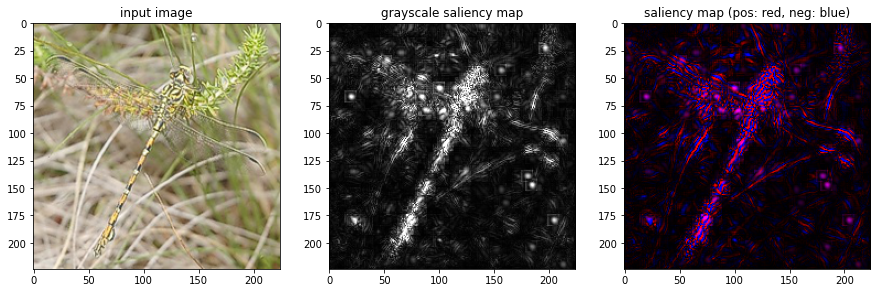

Vanilla Backpropagation


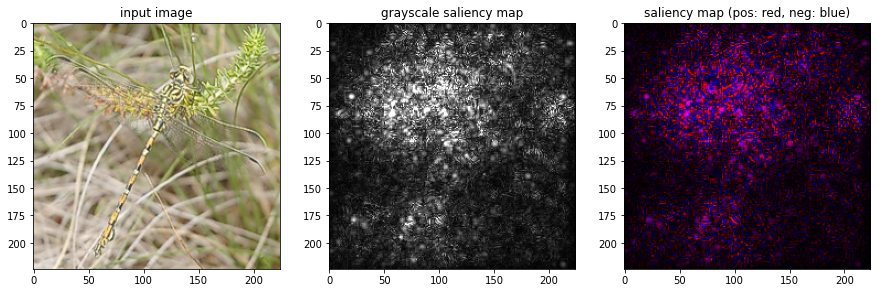

SmoothGrad
Vanilla Backpropagation


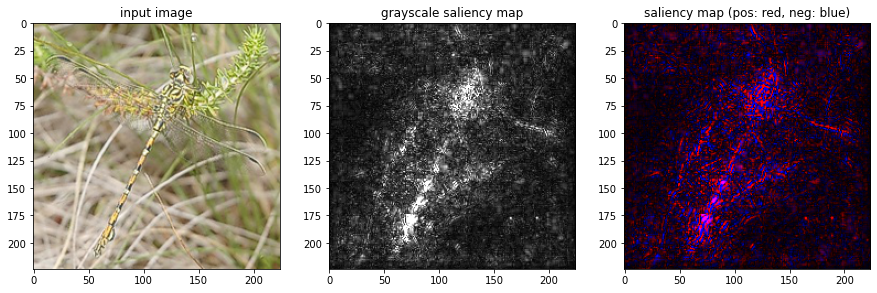

GradCAM


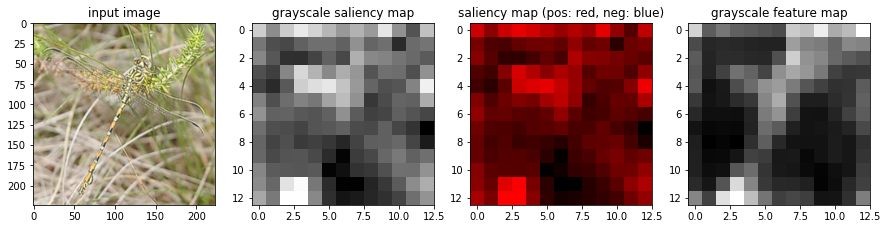

IntegratedGradients


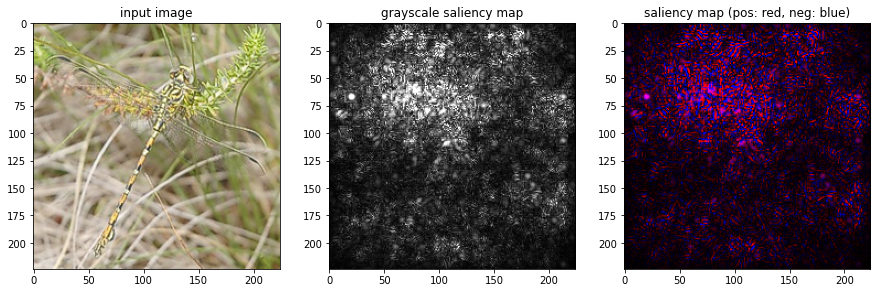

Gradient * Input
Vanilla Backpropagation


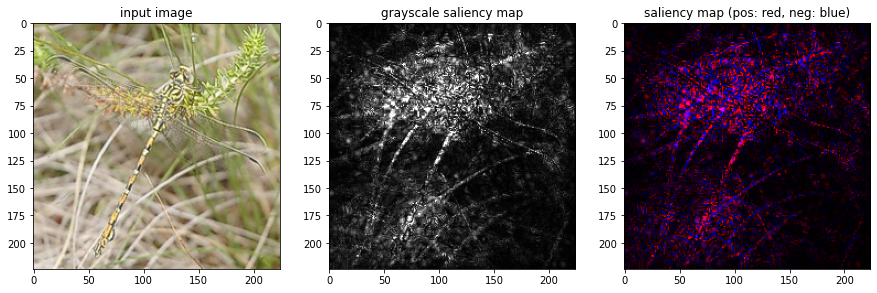

DeepLIFT
Gradient * Input
Vanilla Backpropagation


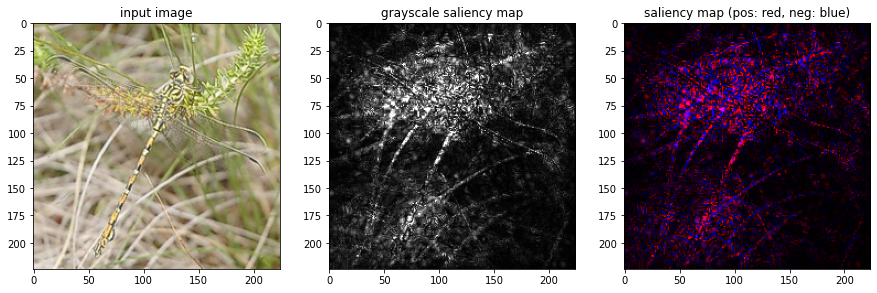

In [4]:
# load one img
# example_index: you can provide the index of the image, or assign it with None (the program will pick one random picture)
# label_index_dict_filepath: a json file showing the match of Imagenet index and CNN correct prediction index
# pic_filepath: filepath of the filefolder of images
(original_image, resized_image, processed_img_tensor, target_class_index, file_name_to_export) = \
get_example_pic_and_preprocess(example_index=None,
                               label_index_dict_filepath = sample_data_filepath+"/imagenet_label_index.json",
                               pic_filepath = sample_data_filepath+"/images")

# decision which layer to want to observe
# 0 means saliency map the the input image, which_layer_to_hook>0 means the saliency map of which_layer_to_hook th intermediate layer
which_layer_to_hook = 0

# decide which pretrained CNN to use
model_name = "alexnet"

# Attention: the pretrained model should be loaded every time using a saliency map method

# GuidedBackprop
# load pre-trained model
pretrained_model = get_pretrained_model(model_name)
saliency_map, feature_map, _ = conduct_saliency_map_method(GuidedBackprop, processed_img_tensor, target_class_index,
                                                        pretrained_model, which_layer_to_hook=which_layer_to_hook)
show_results_for_one_method(resized_image, saliency_map, feature_map, which_layer_to_hook=which_layer_to_hook)

# VanillaBackprop
# load pre-trained model
pretrained_model = get_pretrained_model(model_name)
saliency_map, feature_map, _= conduct_saliency_map_method(VanillaBackprop, processed_img_tensor, target_class_index,
                                                        pretrained_model, which_layer_to_hook=which_layer_to_hook)
show_results_for_one_method(resized_image, saliency_map, feature_map, which_layer_to_hook=which_layer_to_hook)

# SmoothGrad
# load pre-trained model
pretrained_model = get_pretrained_model(model_name)
saliency_map, feature_map, _ = conduct_saliency_map_method(SmoothGrad, processed_img_tensor, target_class_index,
                                                        pretrained_model, which_layer_to_hook=which_layer_to_hook)
show_results_for_one_method(resized_image, saliency_map, feature_map, which_layer_to_hook=which_layer_to_hook)

# GradCAM
# load pre-trained model
pretrained_model = get_pretrained_model(model_name)
saliency_map, feature_map, _ = conduct_saliency_map_method(GradCAM, processed_img_tensor, target_class_index,
                                                        pretrained_model, which_layer_to_hook=11)
show_results_for_one_method(resized_image, saliency_map, feature_map, which_layer_to_hook=11)

# IntegratedGradients
# load pre-trained model
pretrained_model = get_pretrained_model(model_name)
saliency_map, feature_map, _ = conduct_saliency_map_method(IntegratedGradients, processed_img_tensor, target_class_index,
                                                        pretrained_model, which_layer_to_hook=which_layer_to_hook)
show_results_for_one_method(resized_image, saliency_map, feature_map, which_layer_to_hook=which_layer_to_hook)

# GradientxInput
# load pre-trained model
pretrained_model = get_pretrained_model(model_name)
saliency_map, feature_map, _ = conduct_saliency_map_method(GradientxInput, processed_img_tensor, target_class_index,
                                                        pretrained_model, which_layer_to_hook=which_layer_to_hook)
show_results_for_one_method(resized_image, saliency_map, feature_map, which_layer_to_hook=which_layer_to_hook)

# DeepLIFT
# load pre-trained model
pretrained_model = get_pretrained_model(model_name)
saliency_map, feature_map, _ = conduct_saliency_map_method(DeepLIFT, processed_img_tensor, target_class_index,
                                                        pretrained_model, which_layer_to_hook=which_layer_to_hook)
show_results_for_one_method(resized_image, saliency_map, feature_map, which_layer_to_hook=which_layer_to_hook)

### show them together

44 ['/home/users/wangad/Projects/saliency_maps/on_github/data/images/n02129165_6654_lion.jpg', 291] is chosen.
Vanilla Backpropagation
Guided Backpropagation
SmoothGrad
Vanilla Backpropagation
IntegratedGradients
Gradient * Input99009900990154
Vanilla Backpropagation
DeepLIFT
Gradient * Input
Vanilla Backpropagation
27 ['/home/users/wangad/Projects/saliency_maps/on_github/data/images/n01910747_17159_jellyfish.jpg', 107] is chosen.
Vanilla Backpropagation
Guided Backpropagation
SmoothGrad
Vanilla Backpropagation
IntegratedGradients
Gradient * Input99009900990154
Vanilla Backpropagation
DeepLIFT
Gradient * Input
Vanilla Backpropagation
88 ['/home/users/wangad/Projects/saliency_maps/on_github/data/images/n02391049_738_zebra.jpg', 340] is chosen.
Vanilla Backpropagation
Guided Backpropagation
SmoothGrad
Vanilla Backpropagation
IntegratedGradients
Gradient * Input99009900990154
Vanilla Backpropagation
DeepLIFT
Gradient * Input
Vanilla Backpropagation
26 ['/home/users/wangad/Projects/salienc

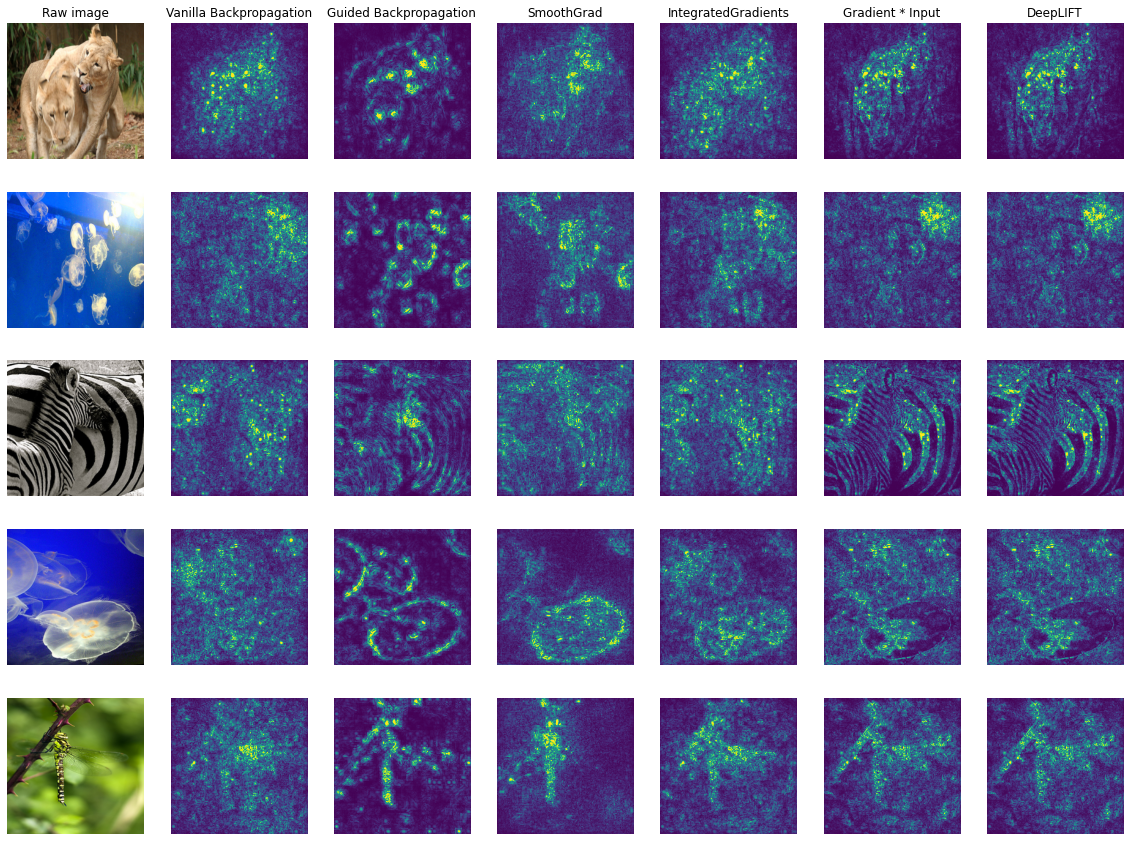

In [5]:
# decide which pretrained CNN to use
model_name = "alexnet"

# decision which layer to want to observe
# 0 means saliency map the the input image, which_layer_to_hook>0 means the saliency map of which_layer_to_hook th intermediate layer
which_layer_to_hook = 0

fig = plt.figure(figsize=(20, 15))

num_of_examples = 5
num_of_saliency_methods = 6

gs = gridspec.GridSpec(num_of_examples, num_of_saliency_methods+1)

for i in range(num_of_examples):
    (original_image, resized_image, processed_img_tensor, target_class_index, file_name_to_export) = \
    get_example_pic_and_preprocess(example_index=None,
                                   label_index_dict_filepath = sample_data_filepath+"/imagenet_label_index.json",
                                   pic_filepath = sample_data_filepath+"/images")
    for j, METHOD in enumerate(["Raw image", VanillaBackprop, GuidedBackprop, SmoothGrad, IntegratedGradients, GradientxInput, DeepLIFT]):
        ax = fig.add_subplot(gs[i,j])
        if METHOD == "Raw image":
            ax.imshow(resized_image)
            ax.axis('off')
            if i==0:
                ax.set_title(METHOD)
        else:
            pretrained_model = get_pretrained_model(model_name)
            saliency_map, feature_map, method = conduct_saliency_map_method(METHOD, processed_img_tensor, target_class_index,
                                                                    pretrained_model, which_layer_to_hook=which_layer_to_hook)
            grayscale_saliency_map, grayscale_feature_map, pos_neg_saliency_map = process_results_for_one_method(saliency_map, feature_map)
            ax.imshow(grayscale_saliency_map)
            ax.axis('off')
            if i==0:
                ax.set_title(method.toString())

plt.savefig('saliency_maps.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)